In [1]:
from os import path
import json
from gensim.models import KeyedVectors
import pandas as pd
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.optim import SGD
from torch.optim.lr_scheduler import ExponentialLR
import matplotlib.pyplot as plt

base = "/content/drive/MyDrive/NLP100/ch09"

fp_train = "80/train.csv"
fp_valid = "80/valid.csv"
fp_words = "80/word_ids.json"
fp_model = "GoogleNews-vectors-negative300.bin"
df_train = pd.read_csv(path.join(base, fp_train), index_col=0)
df_valid = pd.read_csv(path.join(base, fp_valid), index_col=0)
word_ids = json.load(open(path.join(base, fp_words), "r"))
model_vec = KeyedVectors.load_word2vec_format(path.join(base, fp_model), binary=True)
df_train.head()

,TITLE,URL,PUBLISHER,CATEGORY,STORY,HOSTNAME,TIMESTAMP
ID,,,,,,,
311098,RPT-Fitch Updates EMEA Consumer ABS Rating Cri...,http://in.reuters.com/article/2014/06/24/fitch...,Reuters,0,d3tIMfB2mg-9MZM4G_jGTEiRVl3jM,in.reuters.com,1403633888597
49198,"Gurlitt Wants to Return Nazi-Looted Art, Suedd...",http://www.businessweek.com/news/2014-03-26/gu...,Businessweek,2,dWeC4g3bvX-bI6MKAcxt43Jp7MzSM,www.businessweek.com,1395886231417
410578,"UPDATE 1-Fairfax Financial, CEO probed over po...",http://in.reuters.com/article/2014/08/01/fairf...,Reuters,0,d6s61cXf9rASExMO8inpkRujc9VTM,in.reuters.com,1406929609070
270668,Angelina Jolie - Angelina Jolie Will Not Tight...,http://www.contactmusic.com/story/angelina-jol...,Contactmusic.com,2,d7SbUKanRaD34YMwE64lo09d_qCnM,www.contactmusic.com,1401828902205
301656,Patent Officials Cancel the Washington Redskin...,http://www.businessweek.com/articles/2014-06-1...,Businessweek,0,dXVU3KhKpHSxleMNmc46pQj6e5zwM,www.businessweek.com,1403113194649


In [2]:
num_words_of_title = max([len(title.split()) for title in df_train["TITLE"]])


def title_to_ids(t):
  res = [0 for _ in range(num_words_of_title)]
  for i, w in enumerate(t.split()):
    if w in word_ids.keys():
      res[i] = word_ids[w]
  return res


title_to_ids("Europe reaches crunch point on banking union")[:5]

[252, 2031, 0, 1500, 4]

In [3]:
X_train = torch.tensor([title_to_ids(title) for title in df_train["TITLE"]])
y_train = torch.tensor(df_train["CATEGORY"].values.astype("int"))
X_valid = torch.tensor([title_to_ids(title) for title in df_valid["TITLE"]])
y_valid = torch.tensor(df_valid["CATEGORY"].values.astype("int"))
print(X_train[:5])

tensor([[ 599, 3939,    0,  ...,    0,    0,    0],
        [6646,  515,    1,  ...,    0,    0,    0],
        [   7,    0, 6648,  ...,    0,    0,    0],
        [ 326,  419,    6,  ...,    0,    0,    0],
        [1521, 1382, 2762,  ...,    0,    0,    0]])


In [4]:
batch_size = 16
num_workers = 2
dataset_train = [(X_i, y_i) for X_i, y_i in zip(X_train, y_train)]
dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
dataset_valid = [(X_i, y_i) for X_i, y_i in zip(X_valid, y_valid)]
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [5]:
num_embeddings = max(word_ids.values()) + 1
embedding_dim = 300
embedding = torch.zeros(num_embeddings, embedding_dim)
for word, i in word_ids.items():
  try:
    embedding[i, :] = torch.tensor(model_vec[word])
  except:
    pass
print(embedding)

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0679,  0.0996,  0.1016,  ..., -0.1040,  0.2422, -0.0942]])


In [6]:
hidden_size = 50


class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.embedding = nn.Embedding.from_pretrained(embedding, padding_idx=0)
    self.rnn = nn.RNN(embedding_dim, hidden_size, batch_first=True)
    self.linear = nn.Linear(hidden_size, 4)
    self.softmax = nn.Softmax(dim=1)

  def forward(self, x):
    hidden = torch.zeros(1, x.size(0), hidden_size).to(device)
    y = self.embedding(x)
    y, hidden = self.rnn(y, hidden)
    y = self.linear(y[:, -1, :])
    y = self.softmax(y)
    return y

if torch.cuda.is_available():
  device = "cuda"
else:
  device = "cpu"
print(f"device: {device}")
model = Model().to(device)
print(model)

device: cuda
Model(
  (embedding): Embedding(10272, 300, padding_idx=0)
  (rnn): RNN(300, 50, batch_first=True)
  (linear): Linear(in_features=50, out_features=4, bias=True)
  (softmax): Softmax(dim=1)
)


In [7]:
learning_rate = 0.01
loss_fn = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)
scheduler = ExponentialLR(optimizer, gamma=0.95)

loss_train = []
correct_train = []
loss_valid = []
correct_valid = []

for epoch in range(10):
  print(f"Epoch {epoch + 1}\n-------------------------------")
  size = len(dataloader_train.dataset)
  for batch, (X, y) in enumerate(dataloader_train):
    X, y = X.to(device), y.to(device)
    loss = loss_fn(model(X), y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if batch % 1000 == 0:
      loss, current = loss.item(), batch * len(X)
      print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
  scheduler.step()

  size = len(dataloader_train.dataset)
  loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader_train:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  loss /= size
  correct /= size
  loss_train.append(loss)
  correct_train.append(correct)

  size = len(dataloader_valid.dataset)
  loss, correct = 0, 0
  with torch.no_grad():
    for X, y in dataloader_valid:
      X, y = X.to(device), y.to(device)
      pred = model(X)
      loss += loss_fn(pred, y).item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
  loss /= size
  correct /= size
  loss_valid.append(loss)
  correct_valid.append(correct)
  print(f"Test Error: \n Accuracy: {(100 * correct):>0.1f}%, Avg loss: {loss:>8f} \n")

Epoch 1
-------------------------------
loss: 1.384190  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079972 

Epoch 2
-------------------------------
loss: 1.249948  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079232 

Epoch 3
-------------------------------
loss: 1.328591  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079177 

Epoch 4
-------------------------------
loss: 1.224669  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079067 

Epoch 5
-------------------------------
loss: 1.265151  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079067 

Epoch 6
-------------------------------
loss: 1.325809  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079008 

Epoch 7
-------------------------------
loss: 1.241532  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.079119 

Epoch 8
-------------------------------
loss: 1.232357  [    0/10672]
Test Error: 
 Accuracy: 42.7%, Avg loss: 0.078992 

Epoch 9
----------------

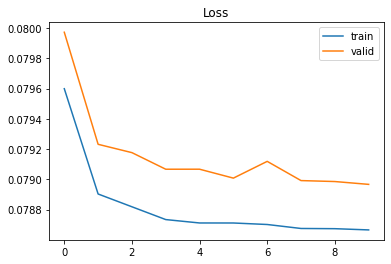

In [8]:
plt.plot(loss_train, label="train")
plt.plot(loss_valid, label="valid")
plt.title("Loss")
plt.legend()
plt.show()

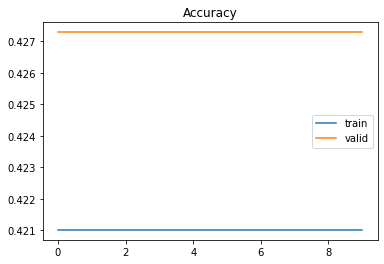

In [9]:
plt.plot(correct_train, label="train")
plt.plot(correct_valid, label="valid")
plt.title("Accuracy")
plt.legend()
plt.show()